In [1]:
import json
import os
import glob

import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import numpy as np
import cv2 as cv
from operator import itemgetter

In [2]:
SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/SciTSR'
# NOTE: change the path to your dataset above 👆

SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_TEST = os.path.join(SCITSR_PATH, 'test')

In [3]:
def get_files(folders, ext):
    total_files = []
    for folder in folders:
        files = glob.glob(folder + '/*.' + ext)
        files.sort()
        total_files.extend(files)
    return total_files

In [4]:
SCITSR_TRAIN_IMG = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = get_files([SCITSR_TRAIN_IMG], 'png')
len(imgs_paths)

12000

In [5]:
def load_img(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"* Error: Unable to read image from {img_path}")
        return None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

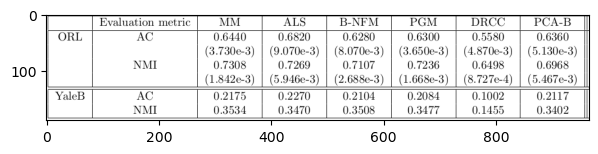

Shape: (188, 966, 3)


In [6]:
# img_path = imgs_paths[15]
img_path = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/img/1504.01777v2.6.png'
img = load_img(img_path)
view_imgs([img])
print(f'Shape: {img.shape}')

In [7]:
def get_table_pos(pdf_path, display=False):
    imgs_pdf = convert_from_path(pdf_path, 150)
    assert len(imgs_pdf) == 1, 'There is more than one pdf image'
    img_pdf = np.array(imgs_pdf[0])
    gray = cv.cvtColor(img_pdf, cv.COLOR_RGB2GRAY)
    thresh, gray = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    coords = cv.findNonZero(gray)
    x, y, w, h = cv.boundingRect(coords)
    left, top, right, bottom = x - 3, y - 3, x + w + 3, y + h + 3
    if display:
        top_left = (round(left), round(top))
        bottom_right = (round(right), round(bottom))
        cv.rectangle(img_pdf, top_left, bottom_right, (0, 0, 255), 3)
        view_imgs([img_pdf])
        print('Shape: ' + str(img_pdf.shape))
    return left, top, right, bottom

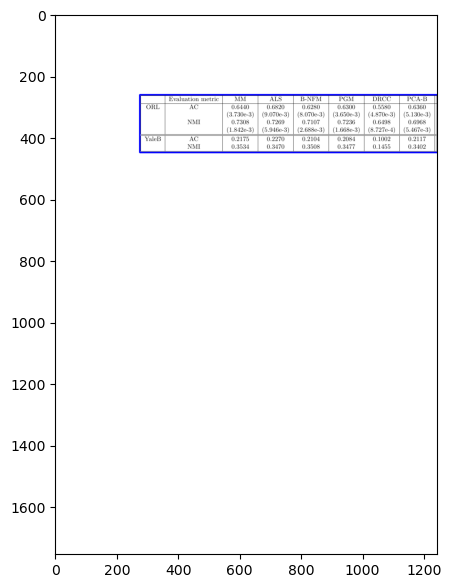

Shape: (1754, 1241, 3)
Top left: (259, 275)
Bottom right: (447, 1244)


In [8]:
img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')

left, top, right, bottom = get_table_pos(img_pdf_path, True)
print(f'Top left: ({top}, {left})')
print(f'Bottom right: ({bottom}, {right})')

In [9]:
def coord_pdf2img(x, y, left, top):
    ratio = 1754 / 842
    new_x = x * ratio - left
    new_y = 1754 - y * ratio - top
    return new_x, new_y

def read_chunk(chunk_path, left, top, display=False): # đọc file chunk để đưa về giá trị 
    Chunks = []
    with open(chunk_path) as f:
      data = json.load(f)
      chunks = data['chunks']
      #print(len(chunks))
      for c in chunks:
          pos = c['pos']
          l,r,t,b = int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])
          if display: print('OG       :', l,t,r,b, '--', c['text'])
          l,t = coord_pdf2img(l,t, left, top)
          r,b = coord_pdf2img(r,b, left, top)
          if display: print('Converted:', int(l), int(t), int(r), int(b))
          if t > b: t, b = b, t
          Chunks.append((c['text'], [int(l), int(t)-5, int(r), int(b)]))
    return Chunks

In [10]:
img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')

chunks = read_chunk(img_chunk_path, left, top, True)

OG       : 177 707 255 712 -- Evaluationmetric
Converted: 93 22 256 11
OG       : 279 707 298 712 -- MM
Converted: 306 22 345 11
OG       : 334 707 353 712 -- ALS
Converted: 420 22 460 11
OG       : 382 707 416 712 -- B-NFM
Converted: 520 22 591 11
OG       : 442 707 466 712 -- PGM
Converted: 645 22 695 11
OG       : 495 707 524 712 -- DRCC
Converted: 756 22 816 11
OG       : 548 707 580 712 -- PCA-B
Converted: 866 22 933 11
OG       : 600 707 678 712 -- PCA-Multinomial
Converted: 974 22 1137 11
OG       : 142 694 163 699 -- ORL
Converted: 20 49 64 38
OG       : 209 694 223 699 -- AC
Converted: 160 49 189 38
OG       : 275 694 302 699 -- 0.6440
Converted: 297 49 354 38
OG       : 330 694 358 699 -- 0.6820
Converted: 412 49 470 38
OG       : 385 694 413 699 -- 0.6280
Converted: 527 49 585 38
OG       : 440 694 468 699 -- 0.6300
Converted: 641 49 699 38
OG       : 495 694 523 699 -- 0.5580
Converted: 756 49 814 38
OG       : 550 694 578 699 -- 0.6360
Converted: 870 49 929 38
OG       : 6

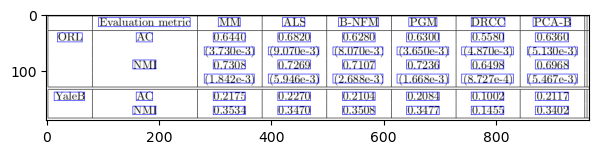

In [11]:
img_draw = img.copy()

for chunk in chunks:
    pos = chunk[1]
    left_top = (pos[0], pos[1])
    bottom_right = (pos[2], pos[3])
    cv.rectangle(img_draw, left_top, bottom_right, (0, 0, 255), 1)

view_imgs([img_draw])

In [12]:
def read_cells(struct_path):  # đọc file structure trả về số lượng dòng số lượng cột và các cột có merge nhau hay ko
    Cells = []
    nRow, nCol = 0, 0
    with open(struct_path) as f:
        data = json.load(f)
        cells = data['cells']
        for c in cells:
            content = c['content']
            if content is None: continue
            id = c['id']
            sr, er = c['start_row'], c['end_row']
            sc, ec = c['start_col'], c['end_col']
            nRow = max(nRow, er+1)
            nCol = max(nCol, ec+1)
            Cells.append({'id': id, 'range': [sr, er, sc, ec], 'content': content})

    Cells = sorted(Cells, key=itemgetter('id'))

    return nRow, nCol, Cells

In [13]:
img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')

n_rows, n_cols, cells = read_cells(img_struct_path)

In [14]:
cells

[{'id': 0, 'range': [0, 0, 0, 0], 'content': []},
 {'id': 1, 'range': [0, 0, 1, 1], 'content': ['Evaluation', 'metric']},
 {'id': 2, 'range': [0, 0, 2, 2], 'content': ['MM']},
 {'id': 3, 'range': [0, 0, 3, 3], 'content': ['ALS']},
 {'id': 4, 'range': [0, 0, 4, 4], 'content': ['B-NFM']},
 {'id': 5, 'range': [0, 0, 5, 5], 'content': ['PGM']},
 {'id': 6, 'range': [0, 0, 6, 6], 'content': ['DRCC']},
 {'id': 7, 'range': [0, 0, 7, 7], 'content': ['PCA-B']},
 {'id': 8, 'range': [0, 0, 8, 8], 'content': ['PCA-Multinomial']},
 {'id': 9, 'range': [1, 1, 0, 0], 'content': ['ORL']},
 {'id': 10, 'range': [1, 1, 1, 1], 'content': ['AC']},
 {'id': 11, 'range': [1, 1, 2, 2], 'content': ['0.6440']},
 {'id': 12, 'range': [1, 1, 3, 3], 'content': ['0.6820']},
 {'id': 13, 'range': [1, 1, 4, 4], 'content': ['0.6280']},
 {'id': 14, 'range': [1, 1, 5, 5], 'content': ['0.6300']},
 {'id': 15, 'range': [1, 1, 6, 6], 'content': ['0.5580']},
 {'id': 16, 'range': [1, 1, 7, 7], 'content': ['0.6360']},
 {'id': 17, '

In [15]:
def update_cells(cells, chunks):
    ChunkSkip = 0
    for i, c in enumerate(cells):
        if c['content'] == [] or i - ChunkSkip >= len(chunks):
            cells[i].update({'pos': [0,0,0,0]})
            ChunkSkip += 1
        else:
            cells[i].update({'pos': chunks[i-ChunkSkip][1]})
        if c['range'][1] > c['range'][0]:
            cells[i].update({'flag': 1}) # flag 1 means rol-span cell
        elif c['range'][3] > c['range'][2]:
            cells[i].update({'flag': 2}) # flag 2 means col-span cell
        else:
            cells[i].update({'flag': 0}) # flag 0 means single cell
        #print(Cells)
        
    return cells       

In [16]:
cells_updt = update_cells(cells, chunks)
cells_updt

[{'id': 0,
  'range': [0, 0, 0, 0],
  'content': [],
  'pos': [0, 0, 0, 0],
  'flag': 0},
 {'id': 1,
  'range': [0, 0, 1, 1],
  'content': ['Evaluation', 'metric'],
  'pos': [93, 6, 256, 22],
  'flag': 0},
 {'id': 2,
  'range': [0, 0, 2, 2],
  'content': ['MM'],
  'pos': [306, 6, 345, 22],
  'flag': 0},
 {'id': 3,
  'range': [0, 0, 3, 3],
  'content': ['ALS'],
  'pos': [420, 6, 460, 22],
  'flag': 0},
 {'id': 4,
  'range': [0, 0, 4, 4],
  'content': ['B-NFM'],
  'pos': [520, 6, 591, 22],
  'flag': 0},
 {'id': 5,
  'range': [0, 0, 5, 5],
  'content': ['PGM'],
  'pos': [645, 6, 695, 22],
  'flag': 0},
 {'id': 6,
  'range': [0, 0, 6, 6],
  'content': ['DRCC'],
  'pos': [756, 6, 816, 22],
  'flag': 0},
 {'id': 7,
  'range': [0, 0, 7, 7],
  'content': ['PCA-B'],
  'pos': [866, 6, 933, 22],
  'flag': 0},
 {'id': 8,
  'range': [0, 0, 8, 8],
  'content': ['PCA-Multinomial'],
  'pos': [974, 6, 1137, 22],
  'flag': 0},
 {'id': 9,
  'range': [1, 1, 0, 0],
  'content': ['ORL'],
  'pos': [20, 33, 6

In [17]:
def split_mask(img, cells):
    h, w, c = img.shape
    rMask = np.ones((h, w), np.uint8)
    cMask = np.ones((h, w), np.uint8)
    for c in cells:
        l, t, r, b = c['pos']
        if c['flag'] != 1:
            rMask[t:b, :] = 0
        if c['flag'] != 2:
            cMask[:, l:r] = 0
    return rMask, cMask

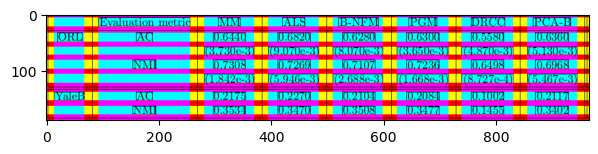

In [31]:
for c in cells_updt:
    lt, rb = (c['pos'][0], c['pos'][1]), (c['pos'][2], c['pos'][3])
    if c['flag'] == 1:
        cv.rectangle(img, lt, rb, (0,255,0), 1)
    elif c['flag'] == 2:
        cv.rectangle(img, lt, rb, (0,0,255), 1)
    else:
        cv.rectangle(img, lt, rb, (255,0,0), 1)
        
rMask, cMask = split_mask(img, cells)
MaskImg = np.stack([np.maximum(rMask, cMask)*255, 255-rMask*255, 255-cMask*255], axis=-1)
MaskImg = np.minimum(img, MaskImg)
view_imgs([MaskImg])

In [32]:
n_row_span_cells, n_col_span_cells = 0, 0

for c in cells_updt:
    if c['flag'] == 1: n_row_span_cells += 1
    elif c['flag'] == 2: n_col_span_cells += 1

n_row_span_cells, n_col_span_cells

(0, 0)

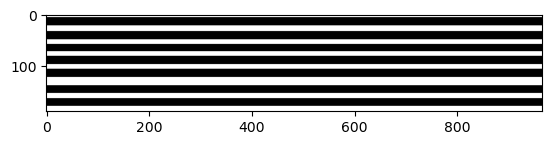

In [19]:
plt.imshow(rMask, cmap='gray')

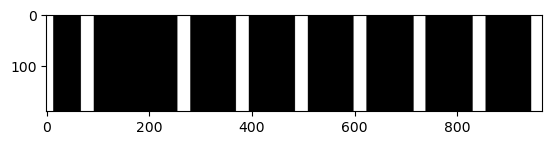

In [20]:
plt.imshow(cMask, cmap='gray')

In [21]:
cMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [22]:
def process_mask(rMask, cMask):
    res = {
        'rows': rMask[:, 0].tolist(),
        'columns': cMask[0, :].tolist()
    }
    return res

In [23]:
res = process_mask(rMask, cMask)
res['rows'][:20], res['columns'][:20]

([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [24]:
# create label folder for Split & Merge module if it hasn't been created
LABEL_TRAIN = os.path.join(SCITSR_TRAIN, 'label')

if not os.path.exists(LABEL_TRAIN):
    os.makedirs(LABEL_TRAIN)

In [25]:
def img_name_from_path(img_path):
    img_name = img_path.split(os.sep)[-1]
    names = img_name.split('.')[:-1]
    return '.'.join(names)

In [26]:
img_name = img_name_from_path(img_path)
img_name

'1504.01777v2.6'

In [27]:
def write_json(json_path, data):
    with open(json_path, 'w') as f:
        json.dump(data, f)

Putting everything together

In [28]:
def prepare_label_split(folder_path: str, json_path: str):
    '''
    Params:
        folder_path -- string, path to either train or test folder
        json_path -- string, path to json file to write ground truth into
    Returns:
        None
    '''
    imgs_folder = os.path.join(folder_path, 'img') # access image folder
    imgs_paths = get_files([imgs_folder], 'png') # get list of image paths inside image folder

    LABELS = {} 
    for i, img_path in enumerate(imgs_paths):
        img = load_img(img_path) # load image as numpy array 
        if img is None: continue
        # view_imgs([img])
        
        # Get table position inside pdf file
        img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')
        left, top, right, bottom = get_table_pos(img_pdf_path)
        
        # Read .chunk file to get coordinates of cells inside table
        # and convert from pdf coordinates to png coordinates
        img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')
        chunks = read_chunk(img_chunk_path, left, top)
        
        # Read .json file from structure folder to know whether a cell is a span-cell or single
        img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
        n_rows, n_cols, cells = read_cells(img_struct_path)

        # update cells so that they have coordinates from chunks
        cells = update_cells(cells, chunks)

        # get row and columns mask (2D) and turn them each into 1D list 
        rMask, cMask = split_mask(img, cells)
        label = process_mask(rMask, cMask)

        # get image name and add to list of labels
        img_name = img_name_from_path(img_path)
        LABELS[img_name] = label
        if (i + 1) % 100 == 0: 
            print(f"Got labels for {i+1} images!")

    with open(json_path, 'w') as f:
        json.dump(LABELS, f)
    return None

In [30]:
LABEL_TRAIN_SPLIT = os.path.join(SCITSR_TRAIN, 'label', 'split_label.json')
# print(LABEL_TRAIN_SPLIT)

# prepare_label_split(SCITSR_TRAIN, LABEL_TRAIN_SPLIT)

In [ ]:
with open(LABEL_TRAIN_SPLIT, 'r') as f:
    data = json.load(f)

len(data)

11971

In [ ]:
test_label = data[img_name]
test_label['rows'] == res['rows'], test_label['columns'] == res['columns'], \
len(test_label['rows']) == img.shape[0], len(test_label['columns']) == img.shape[1]

(True, True, True, True)